# Project UAV

Version 1.0


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from scipy.spatial import distance_matrix
from IPython.display import display, clear_output

#### initial parameters


In [2]:
NUM_GU = 10  # number of ground users

X_MIN = 0  # minimum x-axis [meter]
X_MAX = 100  # maximum x-axis [meter]
Y_MIN = 0  # minimum y-axis [meter]
Y_MAX = 100  # maximum y-axis [mseter]

UAV_ALTITUDE = 10  # altitude of uav [meter]
MAX_BEAM_ANGLE = 60  # maximum beamforming angle [degree]

# calculate maximum beamforming diameter [meter]
MAX_BEAM_DIAMETER = 2 * UAV_ALTITUDE * np.tan(MAX_BEAM_ANGLE * np.pi / 180)

# calculate maximum distance between uav and gu [meter]
MAX_BEAM_DISTANCE = UAV_ALTITUDE / np.cos(MAX_BEAM_ANGLE * np.pi / 180)

X_GRID = 10  # number of x grid
Y_GRID = 10  # number of y grid


TX_POWER = 32  # transmit power [dBm]
F = 1e9  # frequency 1GH [Hz]
C = 299792458  # speed of light [m/s]

UAV_TX_POWER = 30  # uav's transmit power in [dBm]


#### initial variables


In [3]:
gu_bat = np.zeros((NUM_GU,))  # battery of ground user [mWh]


#### define function

In [4]:
def calc_rx_power(d):
    # received power [mWh]
    return 1*10**((TX_POWER - (20*np.log10((4*np.pi*d*F)/C)))/10) * 1000

#### generate variables


In [5]:
# generate ground user location randomly x,y,z [meters]
gu_x = np.random.uniform(low=X_MIN, high=X_MAX, size=(NUM_GU,))
gu_y = np.random.uniform(low=Y_MIN, high=Y_MAX, size=(NUM_GU,))
gu_z = np.zeros((NUM_GU,))

gu_x = np.array([
    9.04330840e+01, 9.96817955e+01, 7.63398634e+01, 8.98037139e+01, 7.22245261e+01, 
    8.36605843e+01, 10.27225613e-0, 4.05986793e+01, 5.80821532e+01, 9.93099118e+01
])

gu_y = np.array([
    13.73014649e+0, 78.77941627, 60.47122501, 71.19842815, 70.31373701, 
    77.84923832, 60.52589075, 10.41285009, 85.11544206, 46.38436827
])

gu_z = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

gu_xyz = np.array((gu_x,gu_y,gu_z)).T

# print
# gu_x, gu_y, gu_z


In [6]:
# generate meshgrid
tmp_x = np.linspace(X_MIN + X_GRID / 2, X_MAX - X_GRID / 2, X_GRID)
tmp_y = np.linspace(Y_MIN + Y_GRID / 2, Y_MAX - Y_GRID / 2, Y_GRID)
GRID = np.array(np.meshgrid(tmp_x, tmp_y))

# GRID

In [7]:
# generate uav location
# x position of uav 0,1,...,GRID_SIZE-1
uav_x_pos = 1
# y position of uav 0,1,...,GRID_SIZE-1
uav_y_pos = 6

uav_x = GRID[0, uav_y_pos, uav_x_pos]
uav_y = GRID[1, uav_y_pos, uav_x_pos]
uav_z = UAV_ALTITUDE  # uav's altitude [meter]

# print
# uav_x, uav_y, uav_z


#### plot environment


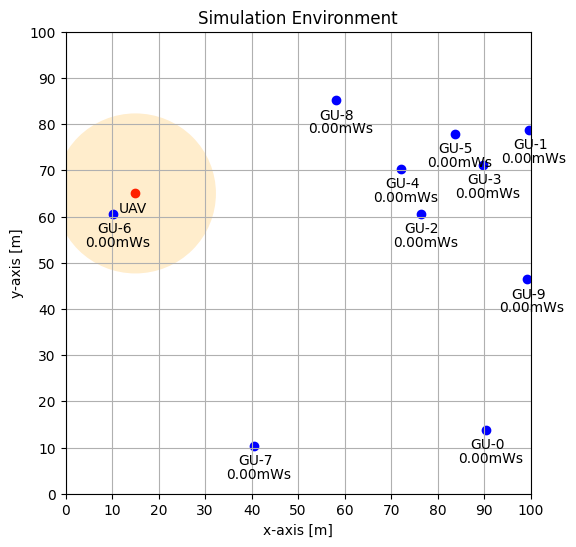

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

plt.scatter(x=uav_x, y=uav_y, c="red")
plt.text(x=uav_x - 3.5, y=uav_y - 4, s=f"UAV")
beam_circle = Ellipse(
    xy=(uav_x, uav_y),
    width=MAX_BEAM_DIAMETER,
    height=MAX_BEAM_DIAMETER,
    angle=0,
    edgecolor="none",
    facecolor="orange",
    alpha=0.2,
)
uav_beam = ax.add_patch(beam_circle)


for i in range(NUM_GU):
    plt.scatter(x=gu_x[i], y=gu_y[i], c="blue")
    plt.text(x=gu_x[i] - 3.5, y=gu_y[i] - 4, s=f"GU-{i}")
    plt.text(x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]:.2f}mWs")


plt.xlabel("x-axis [m]")
plt.ylabel("y-axis [m]")
plt.title("Simulation Environment")
plt.xticks(np.arange(X_MIN, X_MAX + 1, X_GRID))
plt.yticks(np.arange(Y_MIN, Y_MAX + 1, Y_GRID))
plt.xlim(X_MIN, X_MAX)
plt.ylim(Y_MIN, Y_MAX)
plt.grid()
plt.show()

#### uav take action example


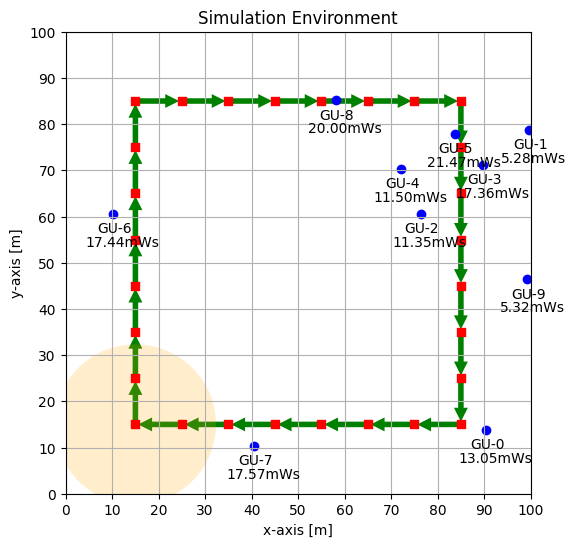

In [9]:
# position of uav at time n
uav_x_pos, uav_y_pos = np.array([
    [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8],
    [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8],
    [8, 7], [8, 6], [8, 5], [8, 4], [8, 3], [8, 2], [8, 1],
    [7, 1], [6, 1], [5, 1], [4, 1], [3, 1], [2, 1], [1, 1],
]).T

tmp_uav_y, tmp_uav_x = GRID[:, uav_x_pos, uav_y_pos]

gu_bat = np.zeros((NUM_GU,))

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_title("Simulation Environment")
ax.set_xticks(np.arange(X_MIN, X_MAX + 1, X_GRID))
ax.set_yticks(np.arange(Y_MIN, Y_MAX + 1, Y_GRID))
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.grid()

current_batt = []
for i in range(NUM_GU):
    ax.scatter(x=gu_x[i], y=gu_y[i], c="blue")
    ax.text(x=gu_x[i] - 3.5, y=gu_y[i] - 4, s=f"GU-{i}")
    current_batt.append(
        ax.text(x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]:.2f}mWs"))

for t in range(len(tmp_uav_x) - 1):

    uav_xyz = np.append(GRID[:, uav_y_pos[t+1], uav_x_pos[t+1]], 10)
    distance_uav2gu = distance_matrix([uav_xyz], gu_xyz)
    rx_power = calc_rx_power(distance_uav2gu)

    gu_bat += (rx_power*(distance_uav2gu <= MAX_BEAM_DISTANCE))[0]

    arrow = mpatches.FancyArrowPatch(
        (tmp_uav_x[t], tmp_uav_y[t]),
        (tmp_uav_x[t + 1], tmp_uav_y[t + 1]),
        edgecolor="none",
        facecolor="green",
        mutation_scale=20,
        zorder=0
    )
    tmp = ax.add_patch(arrow)

    scatter_uav = ax.scatter(
        x=tmp_uav_x[t+1], y=tmp_uav_y[t+1], c="red", marker="s", zorder=1)

    beam_circle.remove()
    beam_circle = Ellipse(
        xy=(tmp_uav_x[t+1], tmp_uav_y[t+1]),
        width=MAX_BEAM_DIAMETER,
        height=MAX_BEAM_DIAMETER,
        angle=0,
        edgecolor="none",
        facecolor="orange",
        alpha=0.2,
        zorder=0,
    )

    uav_beam = ax.add_patch(beam_circle)

    for i in range(NUM_GU):
        current_batt[i].remove()
        current_batt[i] = ax.text(
            x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]:.2f}mWs")

    display(fig)
    clear_output(wait=True)
    time.sleep(0.05)